In [551]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings

In [552]:
warnings.filterwarnings('ignore')

In [553]:
file_path = '../../volza/magnesium/magnesium.csv'
data = pd.read_csv(file_path)

# Only keep YY-MM-DD
data['Date'] = pd.to_datetime(data['Date'].str.split(' ').str[0])
data.sort_values('Date', inplace=True)

# Set 'Date' as the index
data.set_index('Date', inplace=True)

In [554]:
# Filter for specific countries
countries_of_interest = ['China', 'Israel', 'Turkey']
filtered_data = data[data['Country of Origin'].isin(countries_of_interest)]
filtered_data[['Country of Origin', 'Value']]

,Country of Origin,Value
Date,,
2020-01-01,China,10015044.94
2020-01-01,China,0.00
2020-01-01,China,215385.39
2020-01-01,China,0.00
2020-01-01,China,2443624.72
...,...,...
2022-12-31,China,82125.00
2022-12-31,China,80709.47
2022-12-31,China,148000.00


In [555]:
grouped_data = filtered_data.groupby('Country of Origin')

In [556]:
# Initialize a dictionary to store the autoregression models and predictions for each country
ar_models = {}
predictions = {}

In [557]:
# # Loop through each country and perform autoregression
# for country, group in grouped_data:
#     # Resample the data monthly and take the mean of the 'Value' column
#     monthly_data = group['Value'].resample('M').mean()

#     # Drop NaN values
#     monthly_data.dropna(inplace=True)

#     # Plotting the time series
#     plt.figure(figsize=(12, 6))
#     plt.plot(monthly_data.index, monthly_data, label='Observed')
#     plt.title(f'Time Series of Value - {country}')
#     plt.xlabel('Date')
#     plt.ylabel('Value')
#     plt.grid(True)

#         # Setting monthly ticks and formatting date labels
#     plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
#     plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#     plt.xticks(rotation=90)  # Rotate date labels for better spacing

#     # Check for stationarity
#     result = adfuller(monthly_data)
#     if result[1] < 0.05:  # Assuming a significance level of 5%
#         # Data is stationary, we can use autoregression
#         model = AutoReg(monthly_data, lags=1).fit()
#         ar_models[country] = model

#         num_future_periods = 36  # Number of periods to predict
#         start_prediction = len(monthly_data)
#         end_prediction = start_prediction + num_future_periods - 1

#         prediction = model.predict(start=start_prediction, end=end_prediction)
#         predictions[country] = prediction

#         # Generate future dates for predictions
#         start_date = monthly_data.index[0]
#         future_dates = pd.date_range(start=start_date, periods=num_future_periods, freq='M')

#         # Plotting the predictions
#         if len(prediction) == len(future_dates):
#             plt.plot(future_dates, prediction, label='Predicted', linestyle='--')
#         else:
#             print(f"Prediction length mismatch in {country}")
    
#     plt.legend()
#     plt.show()

ValueError: x and y must have same first dimension, but have shapes (13,) and (12,)

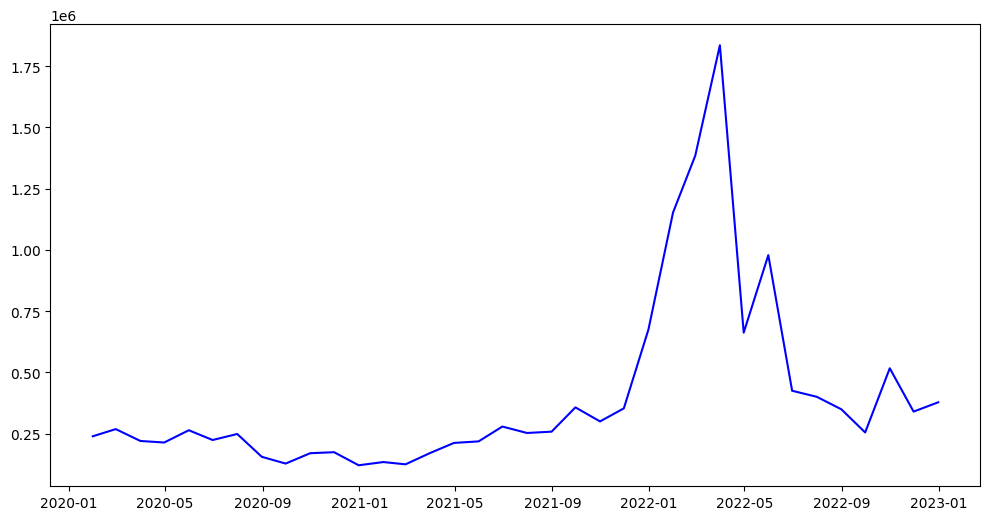

In [558]:

for country, group in grouped_data:
    # Resample the data monthly and take the mean of the 'Value' column
    monthly_data = group['Value'].resample('M').mean()
    monthly_data.dropna(inplace=True)

    # Automatically determine the ARIMA parameters
    auto_model = auto_arima(monthly_data, seasonal=False, stepwise=True, trace=False)
    p, d, q = auto_model.order

    # Fit the ARIMA model
    model = ARIMA(monthly_data, order=(p, d, q))
    arima_model = model.fit()

    # Forecasting the next 12 months
    forecast = arima_model.get_forecast(steps=12)
    prediction = forecast.predicted_mean
    conf_int = forecast.conf_int()

    # Plotting the observed data
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_data.index, monthly_data, label='Observed', color='blue')

    # Plotting the predictions
    future_dates = [monthly_data.index[-1] + pd.DateOffset(months=i) for i in range(1, 13)]
    plt.plot(future_dates, prediction, label='Forecast', linestyle='--', color='red')
    plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='k', alpha=0.1)

    # Setting the chart title and labels
    plt.title(f'Time Series Forecast of Value - {country}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.gca().set_ylim(ymin=0)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=90)

    plt.legend()
    plt.grid(True)
    plt.show()
